<a href="https://colab.research.google.com/github/econ105/AI/blob/main/explainableAIforhousingpriceprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

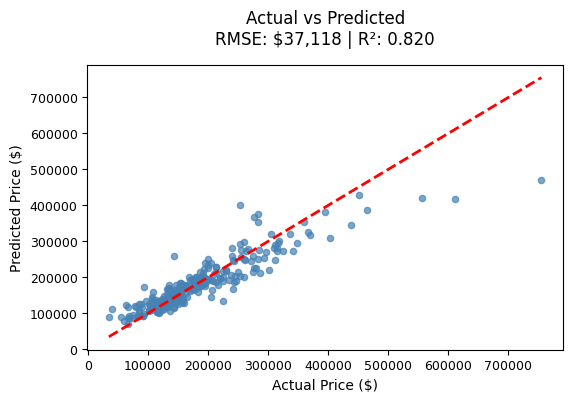

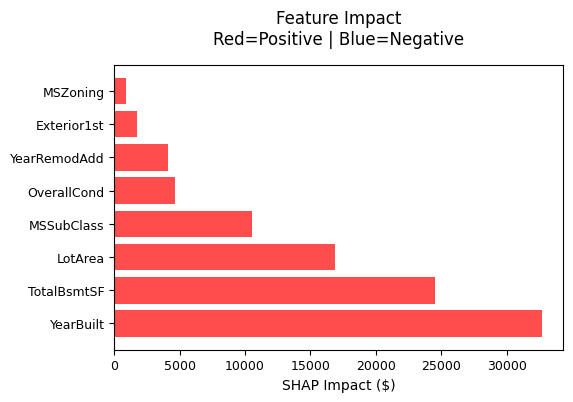

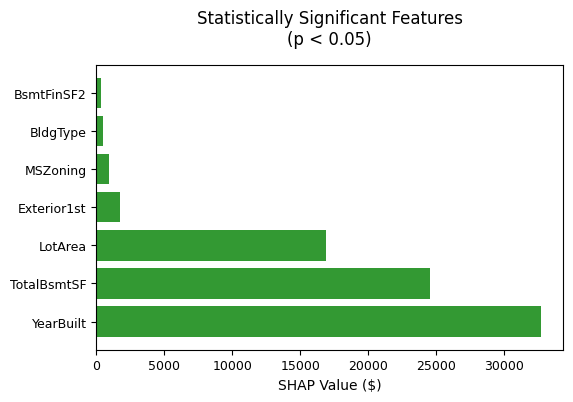

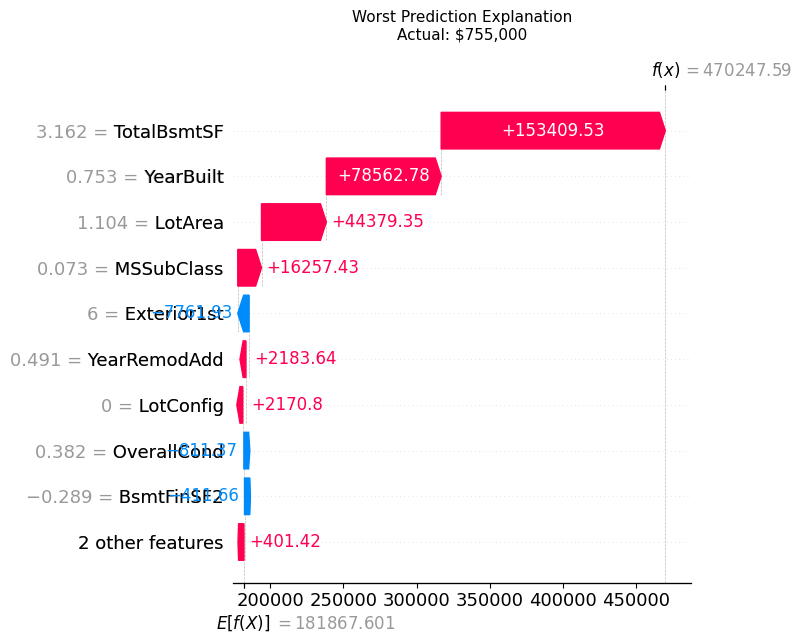

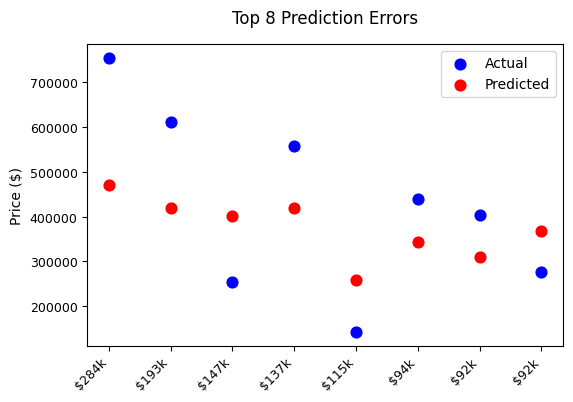

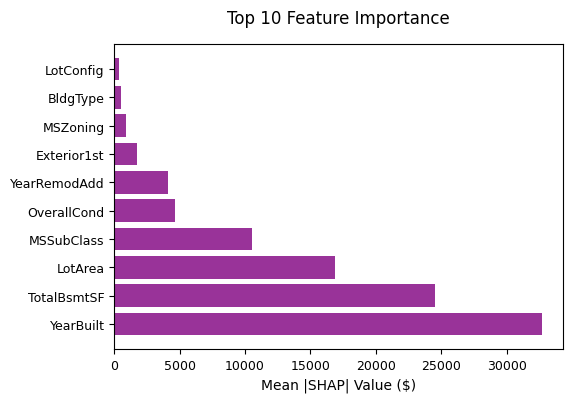

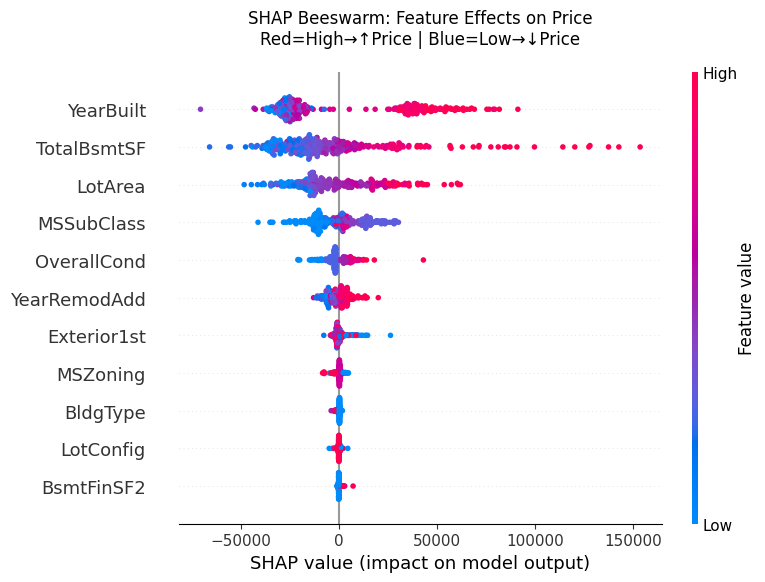

🏠 HOUSE PRICE SHAP ANALYSIS - 7 CLEAN FIGURES
Model: RMSE=$37,118 | R²=0.820

📈 SAVED FIGURES (All ~Half A4 size):
fig1_performance.png   - Actual vs Predicted
fig2_shap_impact.png   - Positive/Negative Impact
fig3_significant.png   - Statistically Significant Features
fig4_waterfall.png     - Worst Prediction Explanation
fig5_errors.png        - Top Prediction Errors
fig6_importance.png    - Feature Importance Ranking
fig7_beeswarm.png      - SHAP Beeswarm (Landscape)

🔍 TOP 5 FEATURES:
    feature  mean_shap  significant
  YearBuilt    32685.0         True
TotalBsmtSF    24503.0         True
    LotArea    16886.0         True
 MSSubClass    10514.0        False
OverallCond     4613.0        False


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import shap
from scipy import stats

# Load and preprocess data (UNCHANGED)
df = pd.read_excel('HousePricePrediction.xlsx', sheet_name='Sheet1')
df = df.dropna(subset=['SalePrice']).drop('Id', axis=1)
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

num_imputer = SimpleImputer(strategy='median')
X[num_cols] = num_imputer.fit_transform(X[num_cols])
cat_imputer = SimpleImputer(strategy='most_frequent')
X[cat_cols] = cat_imputer.fit_transform(X[cat_cols])

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
y_pred = model.predict(X_test)
residuals = y_test.values - y_pred

# SHAP summary
shap_summary = pd.DataFrame({
    'feature': X.columns,
    'mean_shap': np.mean(np.abs(shap_values), axis=0),
    'positive_impact': np.mean(shap_values[shap_values > 0]),
    'negative_impact': np.mean(np.abs(shap_values[shap_values < 0])),
    'p_value': np.zeros(len(X.columns))
})

for i, feature in enumerate(X.columns):
    feature_shap = shap_values[:, i]
    shap_summary.loc[i, 'p_value'] = stats.wilcoxon(feature_shap).pvalue

shap_summary['significant'] = shap_summary['p_value'] < 0.05
shap_summary = shap_summary.sort_values('mean_shap', ascending=False)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# **FIGURE 1: Performance (Half A4 ~ 5.8x4.1 inches)**
plt.figure(figsize=(5.8, 4.1))
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue', s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($)', fontsize=10)
plt.ylabel('Predicted Price ($)', fontsize=10)
plt.title(f'Actual vs Predicted\nRMSE: ${rmse:,.0f} | R²: {r2:.3f}', fontsize=12, pad=15)
plt.tight_layout()
plt.savefig('fig1_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# **FIGURE 2: SHAP Impact Colors (Half A4)**
plt.figure(figsize=(5.8, 4.1))
colors = ['red' if p > n else 'blue' for p, n in zip(shap_summary['positive_impact'], shap_summary['negative_impact'])]
top8 = shap_summary.head(8)
plt.barh(range(8), top8['mean_shap'], color=colors, alpha=0.7)
plt.yticks(range(8), [f[:12]+"..." if len(f)>12 else f for f in top8['feature']], fontsize=9)
plt.xlabel('SHAP Impact ($)', fontsize=10)
plt.title('Feature Impact\nRed=Positive | Blue=Negative', fontsize=12, pad=15)
plt.tight_layout()
plt.savefig('fig2_shap_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# **FIGURE 3: Significant Features (Half A4)**
plt.figure(figsize=(5.8, 4.1))
sig_features = shap_summary[shap_summary['significant']].head(10)
if len(sig_features) > 0:
    plt.barh(range(len(sig_features)), sig_features['mean_shap'], color='green', alpha=0.8)
    plt.yticks(range(len(sig_features)), [f[:12]+"..." if len(f)>12 else f for f in sig_features['feature']], fontsize=9)
plt.xlabel('SHAP Value ($)', fontsize=10)
plt.title('Statistically Significant Features\n(p < 0.05)', fontsize=12, pad=15)
plt.tight_layout()
plt.savefig('fig3_significant.png', dpi=300, bbox_inches='tight')
plt.show()

# **FIGURE 4: Worst Prediction Waterfall (Half A4)**
plt.figure(figsize=(5.8, 4.1))
sample_idx = np.argmax(np.abs(residuals))
shap.waterfall_plot(shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X.columns
), show=False, max_display=10)
plt.title(f'Worst Prediction Explanation\nActual: ${y_test.iloc[sample_idx]:,.0f}', fontsize=11, pad=15)
plt.tight_layout()
plt.savefig('fig4_waterfall.png', dpi=300, bbox_inches='tight')
plt.show()

# **FIGURE 5: Top Errors (Half A4)**
plt.figure(figsize=(5.8, 4.1))
error_indices = np.argsort(np.abs(residuals))[-8:]
sorted_indices = error_indices[::-1]
short_labels = [f"${int(abs(residuals[i]))//1000}k" for i in sorted_indices]
plt.scatter(range(8), y_test.iloc[sorted_indices], c='blue', s=60, label='Actual')
plt.scatter(range(8), y_pred[sorted_indices], c='red', s=60, label='Predicted')
plt.xticks(range(8), short_labels, rotation=45, ha='right', fontsize=9)
plt.ylabel('Price ($)', fontsize=10)
plt.title('Top 8 Prediction Errors', fontsize=12, pad=15)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig('fig5_errors.png', dpi=300, bbox_inches='tight')
plt.show()

# **FIGURE 6: Feature Importance Bar (Half A4)**
plt.figure(figsize=(5.8, 4.1))
top10 = shap_summary.head(10)
plt.barh(range(10), top10['mean_shap'], color='purple', alpha=0.8)
plt.yticks(range(10), [f[:12]+"..." if len(f)>12 else f for f in top10['feature']], fontsize=9)
plt.xlabel('Mean |SHAP| Value ($)', fontsize=10)
plt.title('Top 10 Feature Importance', fontsize=12, pad=15)
plt.tight_layout()
plt.savefig('fig6_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# **FIGURE 7: FULL SHAP BEESWARM (Half A4 landscape)**
plt.figure(figsize=(8.3, 4.1))  # Landscape half A4
shap.summary_plot(shap_values, X_test, feature_names=X.columns, max_display=12, show=False)
plt.title('SHAP Beeswarm: Feature Effects on Price\nRed=High→↑Price | Blue=Low→↓Price', fontsize=12, pad=20)
plt.tight_layout()
plt.savefig('fig7_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# **RESULTS SUMMARY**
print("🏠 HOUSE PRICE SHAP ANALYSIS - 7 CLEAN FIGURES")
print("="*60)
print(f"Model: RMSE=${rmse:,.0f} | R²={r2:.3f}")
print("\n📈 SAVED FIGURES (All ~Half A4 size):")
print("fig1_performance.png   - Actual vs Predicted")
print("fig2_shap_impact.png   - Positive/Negative Impact")
print("fig3_significant.png   - Statistically Significant Features")
print("fig4_waterfall.png     - Worst Prediction Explanation")
print("fig5_errors.png        - Top Prediction Errors")
print("fig6_importance.png    - Feature Importance Ranking")
print("fig7_beeswarm.png      - SHAP Beeswarm (Landscape)")
print("\n🔍 TOP 5 FEATURES:")
print(shap_summary[['feature','mean_shap','significant']].head().round(0).to_string(index=False))
